In [71]:
from plasma_classes import *
from plasma_utils import *
from matplotlib import pyplot as plt
from matplotlib import animation
from tqdm import tqdm

In [72]:
L = 1e-2
N_x = 500
N_p = 5000
h = L/N_x
tau = 5e-13

In [73]:
n0 = 1e17
n1 = n0*N_x*0.8/(N_p)
q = 1.60217e-19
m_e = 9.1093837e-31
m_i = 1.672e-27*131
epsilon = 8.85e-12

In [74]:
eV = 11600

In [75]:
E1_factor = 1.60218e-19

In [76]:
E1 = 18.3*E1_factor
alpha = 0.62

In [77]:
T_e = eV*20
T_i = 600
k_b = 1.38e-23
v_t_e = math.sqrt(3*k_b*T_e/m_e)
vmin_e = -3*v_t_e
vmax_e = 3*v_t_e
v_t_i = math.sqrt(3*k_b*T_i/m_i)
vmin_i = -3*v_t_i
vmax_i = 3*v_t_i

In [78]:
left_wall = Wall(0, L/10, 0, h, "left")
right_wall = Wall(9*L/10, L, 0, h, "right")

In [79]:
walls = (left_wall, right_wall)

In [80]:
r_d = math.sqrt(epsilon * k_b * T_e / (q * q * n0));

In [81]:
r_d

0.00010506222052218572

In [82]:
h

2e-05

In [83]:
tau_courant = 0.25*h/v_t_e
tau_courant

1.5398213577018764e-12

In [84]:
tau_plasma = 1/(math.sqrt(n0*q*q/(m_e*epsilon))/(2*np.pi))
tau_plasma

3.5211733480548816e-10

In [85]:
tau

5e-13

In [86]:
ions = Particles(N_p, n1, q, m_i)
electrons = Particles(N_p, n1, -q, m_e)
nodes = Nodes(N_x)

In [87]:
set_homogeneous(electrons, left_wall.right*h, right_wall.left*h)

In [88]:
set_homogeneous(ions, left_wall.right*h, right_wall.left*h)

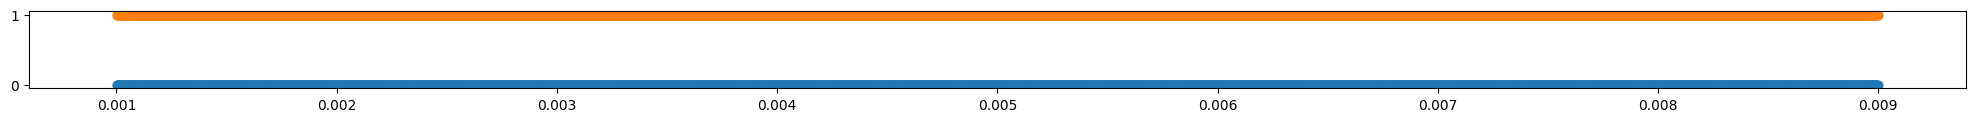

In [89]:
fig, ax = plt.subplots(1, 1)
ax.scatter(electrons.x, np.zeros(electrons.x.shape))
ax.scatter(ions.x, np.ones(ions.x.shape))
fig.set_size_inches((25, 1))


In [90]:
e_integral = get_integral(Maxwell(T_e, k_b, m_e), vmin_e, vmax_e, 100000)
i_integral = get_integral(Maxwell(T_i, k_b, m_i), vmin_i, vmax_i, 100000)

In [91]:
see_integral = get_integral(Maxwell(1*eV, k_b, m_e), vmin_e, vmax_e, 100000)

In [92]:
set_distr(electrons, e_integral, h, tau)
set_distr(ions, i_integral, h, tau)

Particles are already denormalized
Particles are already denormalized


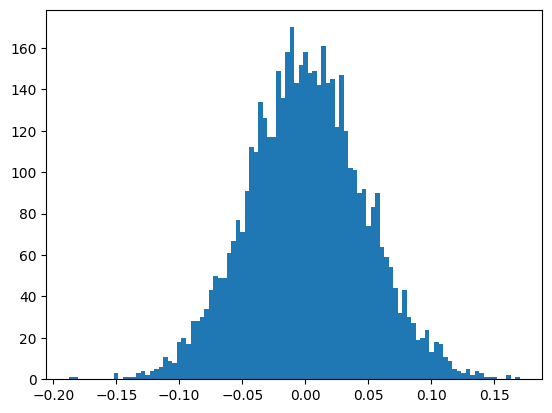

In [93]:
plt.hist(electrons.v, bins = 100)
%matplotlib inline

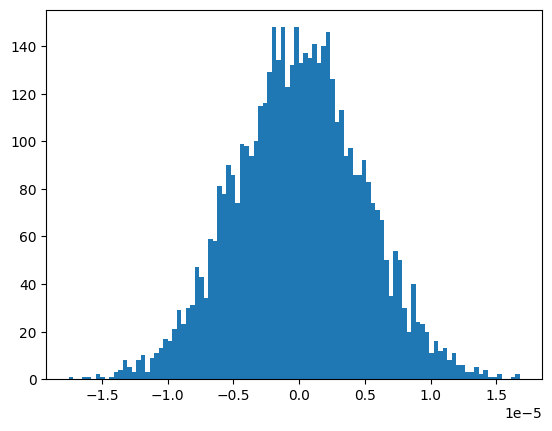

In [94]:
plt.hist(ions.v, bins = 100)
%matplotlib inline

In [95]:
electrons.normalise(h, tau)
ions.normalise(h, tau)

Particles are already normalised
Particles are already normalised


In [96]:
get_rho(nodes, electrons)
get_rho(nodes, ions)

In [97]:
constant_conc = nodes.conc_e[100].copy()*2

In [98]:
calc_fields(nodes, h, epsilon, walls=walls)

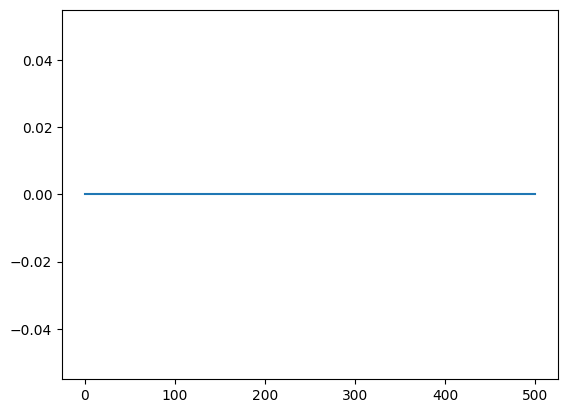

In [99]:
plt.plot(nodes.phi)

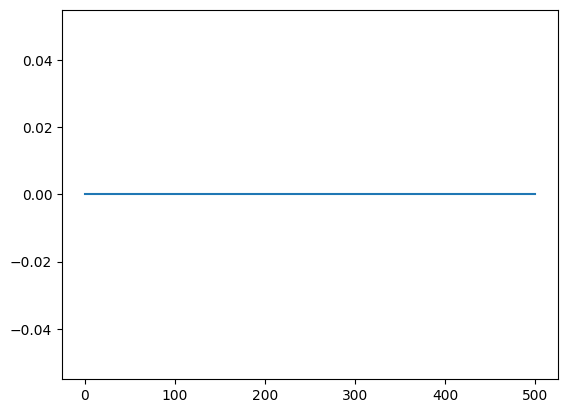

In [100]:
plt.plot(nodes.E)

In [101]:
accel(electrons, nodes, L, h, tau, zerostep=True)
accel(ions, nodes, L, h, tau, zerostep=True)

In [102]:
electron_distrs = []
ion_distrs = []

In [103]:
phi_over_time = []
E_over_time = []

In [104]:
n = 10000

In [105]:
see_dict = {"E1": E1, "alpha": alpha, "h": h, "tau": tau}

In [106]:
energy_dict = {"electric": [], "kinetic": [], "summ": [], "h": h, "tau": tau, "nodes": nodes}

In [107]:
see_dict = {"E1": E1, "alpha": alpha, "h": h, "tau": tau, "see_integral": see_integral}

In [108]:
maxwellise = True

In [109]:
flux = True

In [110]:
n_range = (50, 150)

In [111]:
N = np.sum(range_mask(electrons, n_range))

In [112]:
electrons_over_time = []

In [113]:
every_n_step = 500

In [114]:
conc_history = []

In [115]:
constant_conc

1.9967999999999846e+17

In [116]:

file_path = "test.bin"

In [117]:
every_n_save = 100

In [118]:
import cProfile

In [119]:
def one_iter():
    for i in range(100):
        move(electrons, nodes)
        move(ions, nodes)

        nodes.rho *= 0
        nodes.conc_i *= 0
        nodes.conc_e *= 0
        account_walls((electrons, ions), walls, Energy=energy_dict)
        get_rho(nodes, electrons)
        get_rho(nodes, ions)
        for wall in walls:
            for particles in wall.particles_lst:
                get_rho(nodes, particles)
        calc_fields(nodes, h, epsilon, walls=walls)
        accel(electrons, nodes, L, h, tau)
        accel(ions, nodes,  L, h, tau)

In [120]:
cProfile.run("one_iter()")

         3009534 function calls in 1.508 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.002    0.002    1.508    1.508 2840412596.py:1(one_iter)
       66    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(copy)
      200    0.000    0.000    0.002    0.000 <__array_function__ internals>:177(mean)
      499    0.000    0.000    0.004    0.000 <__array_function__ internals>:177(sum)
        1    0.000    0.000    1.508    1.508 <string>:1(<module>)
      200    0.001    0.000    0.001    0.000 _methods.py:164(_mean)
      200    0.000    0.000    0.000    0.000 _methods.py:67(_count_reduce_items)
      499    0.000    0.000    0.000    0.000 fromnumeric.py:2183(_sum_dispatcher)
      499    0.000    0.000    0.004    0.000 fromnumeric.py:2188(sum)
      200    0.000    0.000    0.000    0.000 fromnumeric.py:3340(_mean_dispatcher)
      200    0.000    0.000    0.002    0.000 fromnumeric.py

In [66]:
for t in tqdm(range(n)):
    try:
        move(electrons, nodes)
        move(ions, nodes)
    except Exception:
        print("number of iteration: ", t)
        break

    nodes.rho *= 0
    nodes.conc_i *= 0
    nodes.conc_e *= 0
    account_walls((electrons, ions), walls, Energy=energy_dict)
    get_rho(nodes, electrons)
    get_rho(nodes, ions)
    for wall in walls:
        for particles in wall.particles_lst:
            get_rho(nodes, particles)
    calc_fields(nodes, h, epsilon, walls=walls)
    accel(electrons, nodes, L, h, tau)
    accel(ions, nodes,  L, h, tau)

    if t % every_n_save == 0:
        save_system_state(t, nodes, (electrons, ions), walls, file_path)

    if maxwellise and t % every_n_step == 0:
        set_distr(electrons, e_integral, h, tau, n_range)

    if flux and t % every_n_step == 0 and t != 0:
        constant_flux((electrons, ions), nodes, constant_conc, n_range)

100%|██████████| 10000/10000 [02:13<00:00, 74.76it/s]


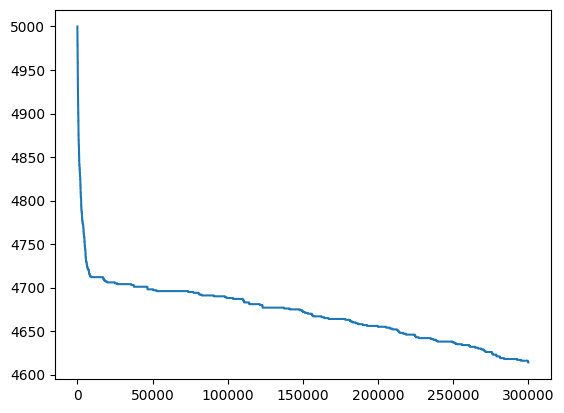

In [163]:
plt.plot(electrons_over_time)

MovieWriter imagemagick unavailable; using Pillow instead.


list index out of range
done!


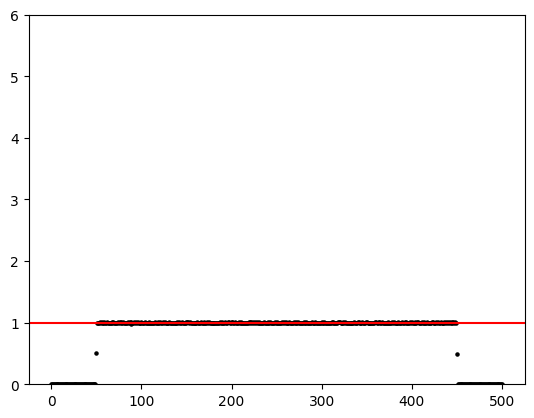

In [156]:
try:
    fig, ax = plt.subplots()

    #  Создаем функцию, генерирующую картинки
    #  для последующей "склейки":
    def animate(i):
        ax.clear()
        ax.set_ylim((0, 6))
        line = ax.scatter(np.arange(501), conc_history[i*50]/1e17, color="k", s=5)
        ax.axhline(constant_conc/2e17, color="r")
        
        return line

    #  Создаем объект анимации:
    sin_animation = animation.FuncAnimation(fig, 
                                        animate, 
                                        frames=range(n),
                                        interval = 5,
                                        repeat = False)

    #  Сохраняем анимацию в виде gif файла:
    sin_animation.save('results/conc_over_time.gif',
                    writer='imagemagick', 
                    fps=30)
except Exception as e:
    print(e)
    print("done!")

In [165]:
central_phi = np.array([x[100] for x in phi_over_time])

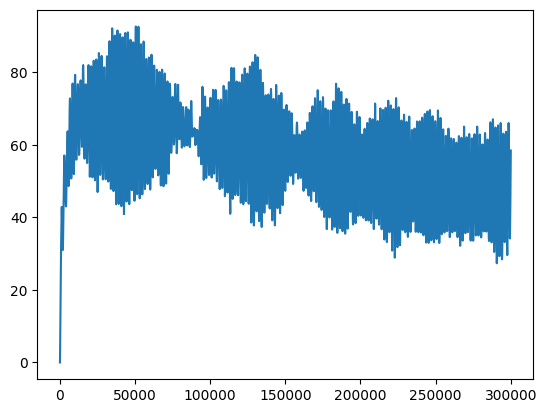

In [166]:
plt.plot(central_phi)

In [155]:
phi_spectre = np.fft.rfft(central_phi)

c:\Users\s\PlasmaPython\PlasmaPython\.venv\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


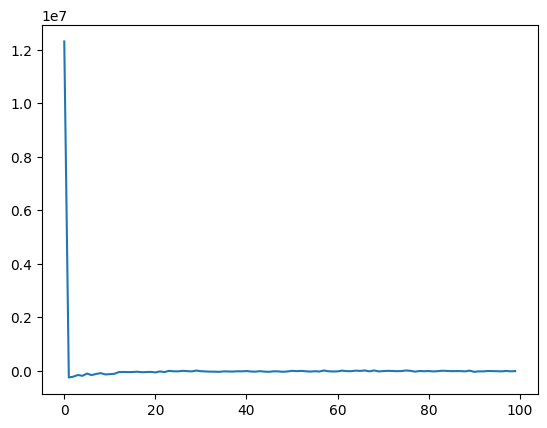

In [156]:
plt.plot(phi_spectre[:100])

In [141]:
tmax = np.argmin(phi_spectre[10:100])

In [142]:
w_exp = tmax*2*np.pi/(n*tau)/1e10
w_exp

1.4451326206513049

In [145]:
w_theory = math.sqrt(n0*q*q/(m_e*epsilon))/1e10
w_theory

1.784401018101099

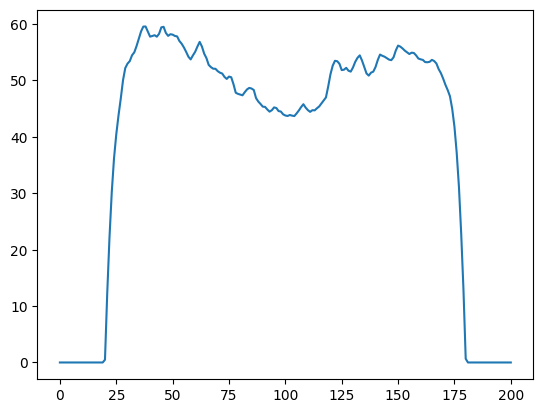

In [157]:
plt.plot(phi_over_time[-1])

In [167]:
electrons.n_macro

4614

In [168]:
ions.n_macro

4760

MovieWriter imagemagick unavailable; using Pillow instead.


list index out of range
done!


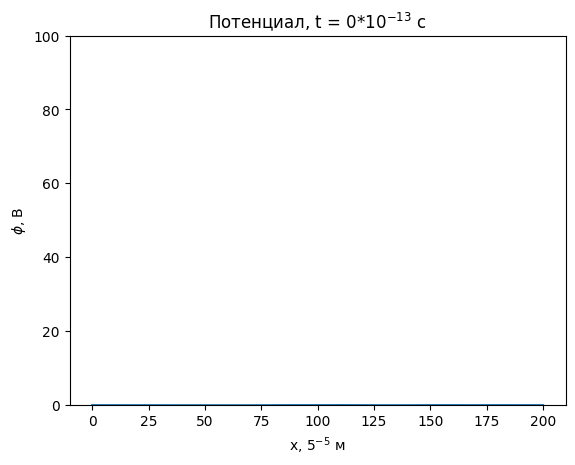

In [169]:
try:
    fig, ax = plt.subplots()

    #  Создаем функцию, генерирующую картинки
    #  для последующей "склейки":
    def animate(i):
        ax.clear()
        line = ax.plot(phi_over_time[i*200])
        ax.set_title("Потенциал, t = " + str(2*i*200)+ r"$*10^{-13}$ c")
        #ax.axvline(x=left_wall.right, color='k', linestyle='--', linewidth=1)
        #ax.set_xlim(left_wall.right, right_wall.left)
        ax.set_ylim(0, 100)
        ax.set_ylabel(r"$\phi$, В")
        ax.set_xlabel(r"x, $5^{-5}$ м")
        return line

    #  Создаем объект анимации:
    sin_animation = animation.FuncAnimation(fig, 
                                        animate, 
                                        frames=range(n),
                                        interval = 5,
                                        repeat = False)

    #  Сохраняем анимацию в виде gif файла:
    sin_animation.save('results/phi_over_time.gif',
                    writer='imagemagick', 
                    fps=30)
except Exception as e:
    print(e)
    print("done!")

MovieWriter imagemagick unavailable; using Pillow instead.


list index out of range
done!


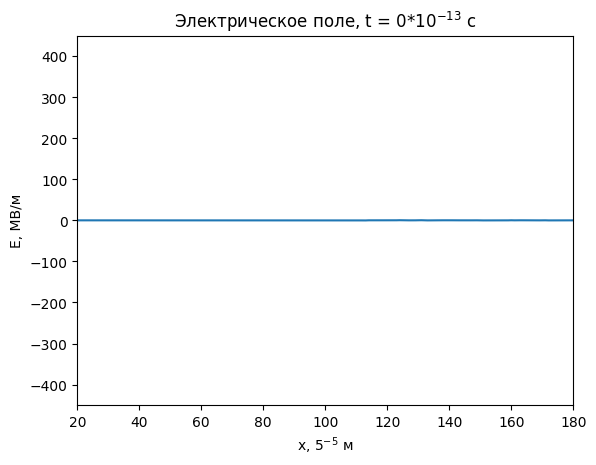

In [165]:
try:
    fig, ax = plt.subplots()

    #  Создаем функцию, генерирующую картинки
    #  для последующей "склейки":
    def animate(i):
        ax.clear()
        line = ax.plot(E_over_time[i*50]/1000)
        ax.set_title("Электрическое поле, t = " + str(2*i*50)+ r"$*10^{-13}$ c")
        ax.set_xlim(left_wall.right, right_wall.left)
        ax.set_ylim(-450, 450)
        ax.set_ylabel(r"E, МВ/м")
        ax.set_xlabel(r"x, $5^{-5}$ м")
        return line

    #  Создаем объект анимации:
    sin_animation = animation.FuncAnimation(fig, 
                                        animate, 
                                        frames=range(n),
                                        interval = 5,
                                        repeat = False)

    #  Сохраняем анимацию в виде gif файла:
    sin_animation.save('results/E_over_time.gif',
                    writer='imagemagick', 
                    fps=30)
except Exception as e:
    print(e)
    print("done!")

MovieWriter imagemagick unavailable; using Pillow instead.


list index out of range
done!


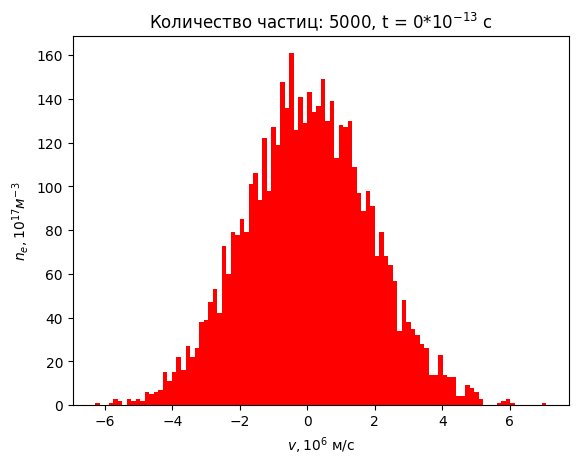

In [166]:
try:
    fig, ax = plt.subplots()

    #  Создаем функцию, генерирующую картинки
    #  для последующей "склейки":
    def animate(i):
        ax.clear()
        # Calculate the bin width based on the data
        data_min = min(np.min(electron_distrs[i*50]/1e6), np.min(ion_distrs[0]/1000))
        data_max = max(np.max(electron_distrs[i*50]/1e6), np.max(ion_distrs[0]/1000))
        bin_width = 2*(np.percentile(electron_distrs[i*50]/1e6, 75) - np.percentile(electron_distrs[i*50]/1e6, 25))/len(electron_distrs[i*50])**(1/3)
        bins = np.arange(data_min, data_max + bin_width, bin_width)

        line = ax.hist(electron_distrs[0]/1e6, bins=100, color="b")
        ax.hist(electron_distrs[i*50]/1e6, bins=100, color = "r")
        ax.set_title("Количество частиц: " + str(len(electron_distrs[i*50])) + 
                     ", t = " + str(2*i*50)+ r"$*10^{-13}$ c")
        ax.set_ylabel(r"$n_e, 10^{17} м^{-3}$")
        ax.set_xlabel(r"$v, 10^{6}$ м/c")
        return line

    #  Создаем объект анимации:
    sin_animation = animation.FuncAnimation(fig, 
                                        animate, 
                                        frames=range(n),
                                        interval = 5,
                                        repeat = False)

    #  Сохраняем анимацию в виде gif файла:
    sin_animation.save('results/electron_distrs_over_time.gif',
                    writer='imagemagick', 
                    fps=30)
except Exception as e:
    print(e)
    print("done!")

MovieWriter imagemagick unavailable; using Pillow instead.


list index out of range
done!


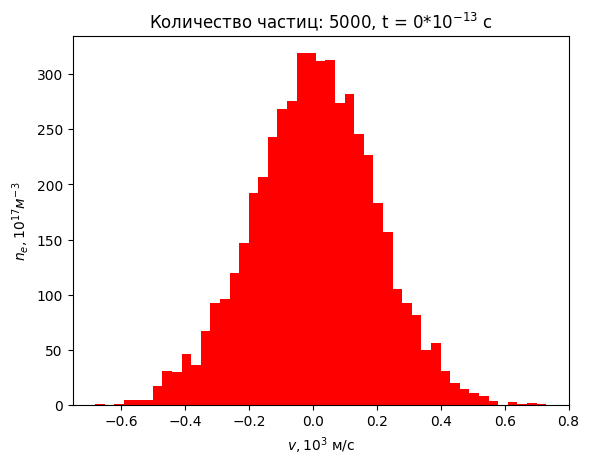

In [167]:
try:
    fig, ax = plt.subplots()

    #  Создаем функцию, генерирующую картинки
    #  для последующей "склейки":
    def animate(i):
        ax.clear()
        # Calculate the bin width based on the data
        data_min = min(np.min(ion_distrs[i*50]/1000), np.min(ion_distrs[0]/1000))
        data_max = max(np.max(ion_distrs[i*50]/1000), np.max(ion_distrs[0]/1000))
        bin_width = 2*(np.percentile(ion_distrs[i*50]/1000, 75) - np.percentile(ion_distrs[i*50]/1000, 25))/len(ion_distrs[i*50])**(1/3)
        bins = np.arange(data_min, data_max + bin_width, bin_width)
        
        line = ax.hist(ion_distrs[0]/1000, bins=bins, color="b")
        ax.hist(ion_distrs[i*50]/1000, bins=bins, color="r")
        
        ax.set_title("Количество частиц: " + str(len(ion_distrs[i*50])) + 
                     ", t = " + str(2*i*50)+ r"$*10^{-13}$ c")
        ax.set_ylabel(r"$n_e, 10^{17} м^{-3}$")
        ax.set_xlabel(r"$v, 10^{3}$ м/c")
        return line

    #  Создаем объект анимации:
    sin_animation = animation.FuncAnimation(fig, 
                                        animate, 
                                        frames=range(n),
                                        interval = 5,
                                        repeat = False)

    #  Сохраняем анимацию в виде gif файла:
    sin_animation.save('results/ion_distrs_over_time.gif',
                    writer='imagemagick', 
                    fps=30)
except Exception as e:
    print(e)
    print("done!")

In [112]:
import os
import imageio

gif_dir = 'results/'
paired_gif_dir = 'paired_gifs/'

SEE_gif_files = [filename for filename in os.listdir(gif_dir) if filename.startswith('SEE') and filename.endswith('.gif')]
reg_gif_files = [filename for filename in os.listdir(gif_dir) if not filename.startswith('SEE') and filename.endswith('.gif')]

for SEE_gif_file in SEE_gif_files:
    SEE_gif_path = os.path.join(gif_dir, SEE_gif_file)
    reg_gif_file = SEE_gif_file.replace('SEE', '').lstrip('_')
    reg_gif_path = os.path.join(gif_dir, reg_gif_file)
    if os.path.exists(reg_gif_path):
        SEE_gif = imageio.mimread(SEE_gif_path, memtest=False)
        reg_gif = imageio.mimread(reg_gif_path, memtest=False)
        paired_gifs = [np.concatenate((reg_frame, SEE_frame), axis=1) for reg_frame, SEE_frame in zip(reg_gif, SEE_gif)]
        paired_gif_path = os.path.join(paired_gif_dir, SEE_gif_file.replace('SEE', 'paired'))
        imageio.mimwrite(paired_gif_path, paired_gifs, format='gif', fps=30)


In [37]:
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt

# Set directory paths
reg_gif_dir = 'path/to/regular/gifs'
SEE_gif_dir = 'path/to/SEE/gifs'
paired_gif_dir = 'path/to/paired/gifs'

# Loop through SEE gifs
for SEE_gif_file in os.listdir(SEE_gif_dir):
    if SEE_gif_file.startswith('SEE'):
        # Load regular gif
        reg_gif_file = SEE_gif_file.replace('SEE', '')
        reg_gif_path = os.path.join(reg_gif_dir, reg_gif_file)
        reg_gif = imageio.mimread(reg_gif_path)

        # Load SEE gif
        SEE_gif_path = os.path.join(SEE_gif_dir, SEE_gif_file)
        SEE_gif = imageio.mimread(SEE_gif_path)

        # Combine frames
        paired_gifs = [np.concatenate((reg_frame, SEE_frame), axis=1) for reg_frame, SEE_frame in zip(reg_gif, SEE_gif)]

        # Add title to each frame
        for i, frame in enumerate(paired_gifs):
            fig, ax = plt.subplots()
            ax.imshow(frame, cmap='gray')
            if i == 0:
                ax.set_title('Regular GIF                          SEE GIF')
            plt.axis('off')

            # Save frame
            paired_gif_path = os.path.join(paired_gif_dir, SEE_gif_file.replace('SEE', 'paired'))
            imageio.imwrite(paired_gif_path, frame)

        # Combine frames into GIF
        paired_gif_path = os.path.join(paired_gif_dir, SEE_gif_file.replace('SEE', 'paired'))
        with imageio.get_writer(paired_gif_path, mode='I', fps=30) as writer:
            for frame in paired_gifs:
                writer.append_data(frame)


FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: 'path/to/SEE/gifs'

In [39]:
ions_over_time = np.array([len(x) for x in ion_distrs])

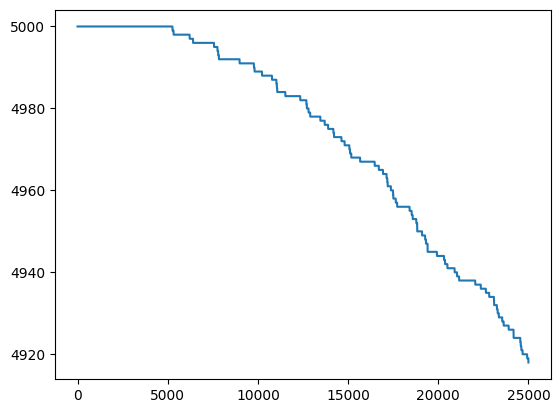

In [40]:
plt.plot(ions_over_time)

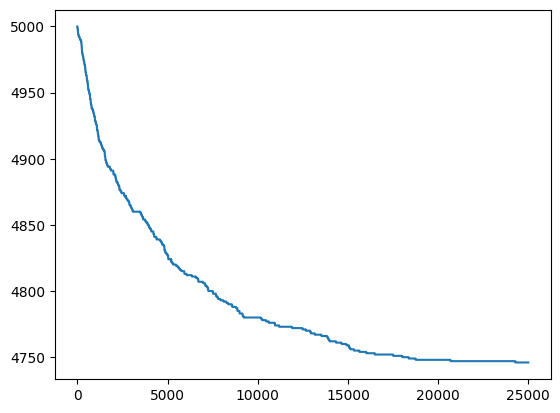

In [41]:
electrons_over_time = np.array([len(x) for x in electron_distrs])
plt.plot(electrons_over_time)


(array([2.50911614e-07, 4.18186024e-07, 1.67274409e-07, 3.34548819e-07,
        3.34548819e-07, 4.18186024e-07, 5.01823228e-07, 2.50911614e-07,
        2.50911614e-07, 4.18186024e-07, 6.69097638e-07, 5.85460433e-07,
        3.34548819e-07, 8.36372047e-07, 5.01823228e-07, 4.18186024e-07,
        9.20009252e-07, 8.36372047e-07, 9.20009252e-07, 1.42183248e-06,
        1.00364646e-06, 2.09093012e-06, 1.14582970e-05, 6.73279498e-05,
        1.47786941e-04, 1.19099380e-04, 3.40403423e-05, 5.01823228e-06,
        1.58910689e-06, 7.52734843e-07, 1.33819528e-06, 1.17092087e-06,
        6.69097638e-07, 5.01823228e-07, 7.52734843e-07, 4.18186024e-07,
        5.85460433e-07, 5.01823228e-07, 4.18186024e-07, 5.01823228e-07,
        4.18186024e-07, 4.18186024e-07, 4.18186024e-07, 5.01823228e-07,
        5.01823228e-07, 1.67274409e-07, 3.34548819e-07, 4.18186024e-07,
        8.36372047e-08, 2.50911614e-07]),
 array([-60222.11855083, -57790.96737177, -55359.81619272, -52928.66501366,
        -50497.513

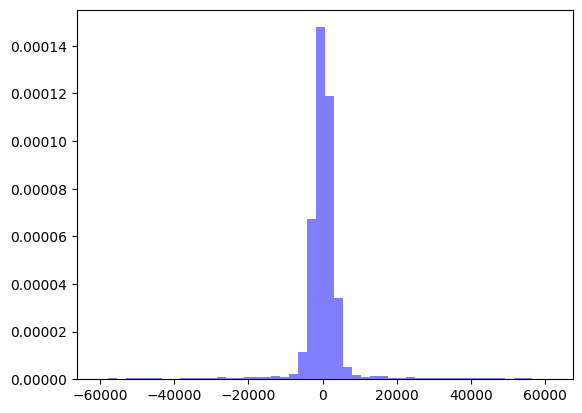

In [44]:
plt.hist(ion_distrs[-1], bins=50, density=True, facecolor='blue', alpha=0.5)

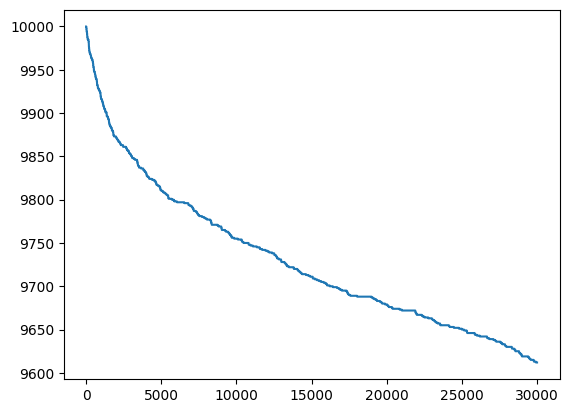

In [39]:
plt.plot(electrons_over_time+ions_over_time)
